In [1]:
from pathlib import Path

arches = (
    "linux-64",
    "win-64",
    "osx-64",
    "noarch",
    "linux-ppc64le",
    "linux-aarch64",
)


def remove_existing(fname):
    if fname.is_file():
        fname.unlink()


# Clean old files first.
path = Path(".")
for arch in arches:
    remove_existing(path.joinpath(f"repodata-{arch}.json"))
    remove_existing(path.joinpath(f"repodata-cf201901-{arch}.json"))

In [2]:
import shutil

import requests


def download_file(url, fname):
    with requests.get(url, stream=True) as r:
        with open(fname, "wb") as f:
            shutil.copyfileobj(r.raw, f)
    return fname

In [3]:
for arch in arches:
    download_file(
        f"https://conda.anaconda.org/conda-forge/{arch}/repodata.json",
        f"repodata-{arch}.json",
    )
    download_file(
        f"https://conda.anaconda.org/conda-forge/label/cf201901/{arch}/repodata.json",
        f"repodata-cf201901-{arch}.json",
    )

In [4]:
import gzip


def read_json(fname):
    with gzip.GzipFile(fname, "r") as f:
        return pd.io.json.loads(f.read())

In [5]:
import glob

import pandas as pd

packages = []
for fname in glob.glob("repodata-*.json"):
    data = read_json(fname)
    df = pd.DataFrame(data["packages"].values())
    df.loc[:, "filename"] = data["packages"].keys()
    packages.append(df)

In [6]:
df = pd.concat(packages, sort=False, ignore_index=True)

In [7]:
df = df.drop_duplicates(subset=["subdir", "filename"])

In [8]:
df.loc[:, "timestamp"] = pd.to_datetime(df.timestamp, unit="ms")

In [9]:
len(df)

333527

Almost 200 thousand artifacts.   Due to us only pulling from master packages that got deprecated during the compiler migration are excluded from
this analysis.

In [10]:
df.timestamp.isnull().sum()

97304

Around half of the packages do not have a creation timestamp in their metadata. thus we kinda have to ignore them

In [11]:
has_ts = df[df.timestamp.notnull()]
has_ts.head()

,build,build_number,depends,license,license_family,md5,name,sha256,size,subdir,...,track_features,app_own_environment,filename,operatingsystem,target-triplet,has_prefix,machine,binstar,requires,noarch
0,hab24e00_0,0.0,"[bzip2 >=1.0.8,<2.0a0]",LGPL v2.1,LGPL,109aa674ad46d60a47d27665fef9ab62,7za,1de2286f20a9b073629b29445a2a953e4f4f11f4608558...,306689.0,win-64,...,NaN,NaN,7za-9.20-hab24e00_0.tar.bz2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,precompiled,0.0,[],BSD-3-Clause,BSD,0cef876fe177bcffdfc5961ba4e48df9,_go_select,d6f32902a4cda8558ce960d7329cb889900275e8d75aac...,3764.0,win-64,...,NaN,NaN,_go_select-1.1.0-precompiled.tar.bz2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,precompiled,0.0,[],BSD-3-Clause,BSD,bb3ee6a03d59dd3738c55f0d12014c6a,_go_select,e73959c2f40291d100ebcd62d1c20ee67eaceff5c82f84...,4800.0,win-64,...,NaN,NaN,_go_select-1.1.1-precompiled.tar.bz2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,cgo,0.0,[],BSD-3-Clause,BSD,752ec912b1b92c868775dd2076977445,_go_select,7cdcb6b71b18ff187c532a3189f7d4eea693831279f311...,3724.0,win-64,...,NaN,NaN,_go_select-1.2.0-cgo.tar.bz2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,cgo,0.0,[],BSD-3-Clause,BSD,23785d38eb43d1ac251bb358d3df627f,_go_select,01e5e0a41ab68cf017d3d68683a3305424571a59b1aa8d...,4818.0,win-64,...,NaN,NaN,_go_select-1.2.1-cgo.tar.bz2,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
import matplotlib.pyplot as plt

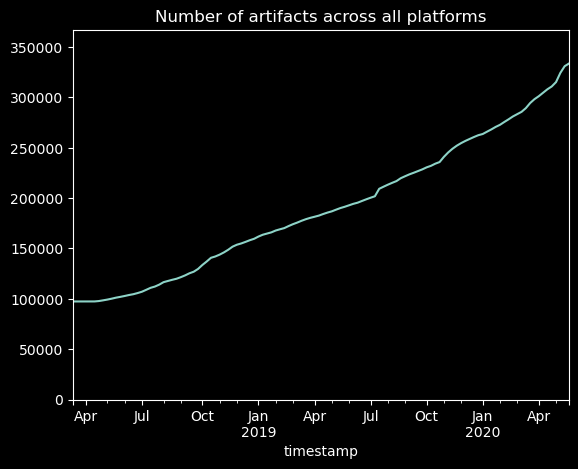

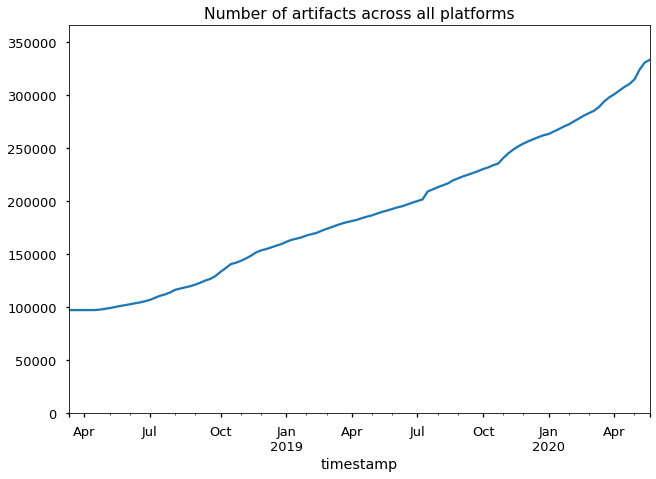

In [26]:
fill_val = "2018-03-01"
df_has = (
    df.fillna(pd.to_datetime(fill_val)).sort_values("timestamp").set_index("timestamp")
)
df_has.loc[:, "package_count"] = list(range(1, len(df_has) + 1))
df_arrival = df_has.groupby(df_has.index.to_period("W")).package_count.max()
for context in [("dark_background", "seaborn-talk"), ("seaborn-talk", )]:
    with plt.style.context(*context):
        fig, ax = plt.subplots()
        df_arrival[df_arrival.index > fill_val].plot(
            title="Number of artifacts across all platforms",
            ylim=(0, df_arrival.max() * 1.1),
            ax=ax
    #         figsize=(16, 9),
        )
        fig.savefig(f"plots/n_artifacts-{'_'.join(context)}.png", bbox_inches='tight', transparent=True)

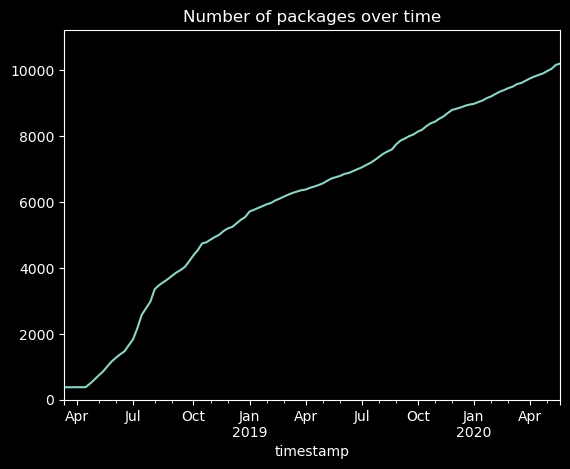

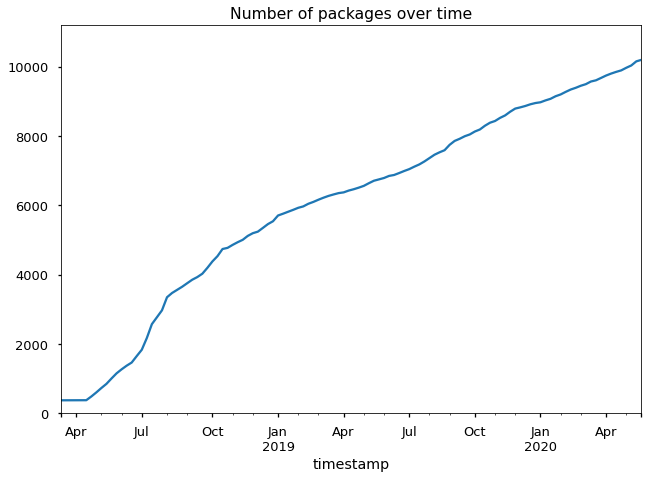

In [25]:
fill_val = "2018-03-01"
x = (
    df.sort_values("timestamp")
    .fillna(pd.to_datetime(fill_val))
    .groupby(df.name)
    .first()
)
first_date = pd.DataFrame(x.timestamp).reset_index().set_index("timestamp").sort_index()
first_date.loc[:, "package_count"] = list(range(1, len(first_date) + 1))
df_first = first_date.groupby(first_date.index.to_period("W")).package_count.max()
for context in [("dark_background", "seaborn-talk"), ("seaborn-talk", )]:
    with plt.style.context(*context):
        fig, ax = plt.subplots()
        df_first[df_first.index > fill_val].plot(
            title="Number of packages over time",
            ylim=(0, df_first.max() * 1.1),
            ax=ax
#             figsize=(16, 9),
        )
        fig.savefig(f"plots/n_feedstocks-{'_'.join(context)}.png", bbox_inches='tight', transparent=True)

In [22]:
arch_df = {}
for arch in arches:
    fill_val = "2018-03-01"
    x = (
        df.sort_values("timestamp")
        .fillna(pd.to_datetime(fill_val))
        .loc[df.subdir == arch]
        .groupby(df.name)
        .first()
    )
    first_date = (
        pd.DataFrame(x.timestamp).reset_index().set_index("timestamp").sort_index()
    )
    first_date.loc[:, "package_count"] = list(range(1, len(first_date) + 1))
    df_first = first_date.groupby(first_date.index.to_period("W")).package_count.max()
    arch_df[arch] = df_first

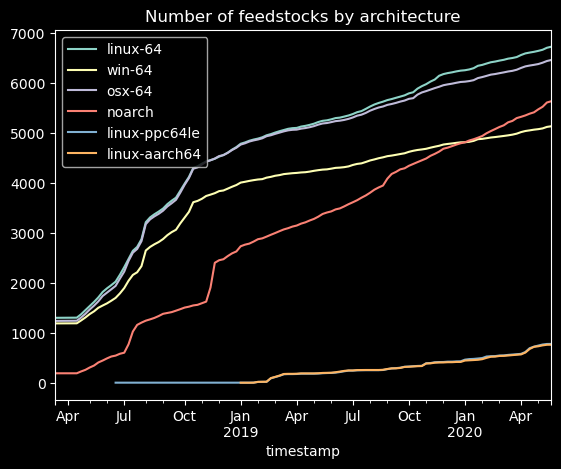

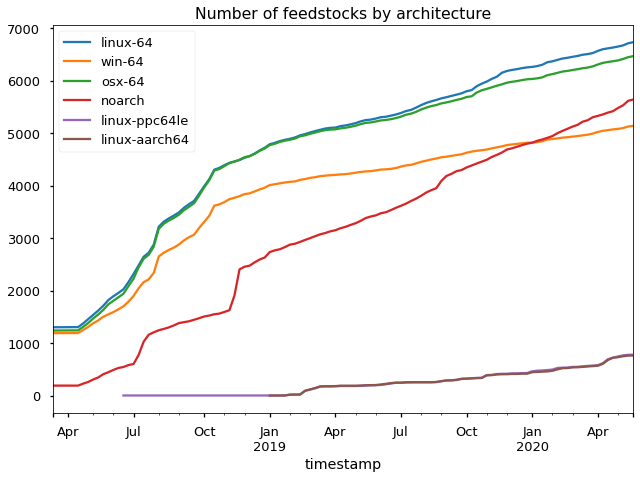

In [24]:
import matplotlib.pyplot as plt

for context in [("dark_background", "seaborn-talk"), ("seaborn-talk", )]:
    with plt.style.context(*context):
        fig, ax = plt.subplots()
        plot_df = pd.DataFrame(arch_df)
        plot_df.ffill()[plot_df.index > fill_val].plot(
            title="Number of feedstocks by architecture",
            ax=ax
        )
        fig.savefig(f"plots/n_feedstocks_by_arch-{'_'.join(context)}.png", bbox_inches='tight', transparent=True)